# **Random Forest Implementation**
*This notebook processes data provided by the [IBM Call for Code Wildfire Challenge](https://community.ibm.com/community/user/datascience/blogs/susan-malaika/2020/11/10/call-for-code-spot-challenge-for-wildfires). The unpreprocessed data is available [on GitHub](https://github.com/Call-for-Code/Spot-Challenge-Wildfires).*

The notebook consists of the following process steps:

*   loading preprocessed data and weather forecast
*   split the data into training, validation and test data
*   normalize data
*   training the model
*   generate predictions on validation data
*   getting feature importances
*   plot result
*   visualization of decision tree


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import time
import random
import math

from google.colab import drive
from matplotlib import pyplot as plt
from collections import deque

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import max_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_tweedie_deviance

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Wildfire_Challenge/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


*   loading preprocessed data and weather forecast



In [ ]:
df = pd.read_csv('Cleansed_Data.csv')

df['Date'] = pd.to_datetime(df['Date'])

df = df.drop(columns=['Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power'], inplace=False)

first_col = df.pop('Estimated_fire_area')
df.insert(0, 'Estimated_fire_area', first_col)

In [ ]:
for i in range(1,5):
  df_new = pd.DataFrame()
  for region in ['NSW', 'VI', 'SA', 'WA', 'NT', 'QL', 'TA']:
    df_region = df[df['Region'] == region].copy()
    for feature in df_region.columns:
      if feature not in ['Estimated_fire_area', 'Date', 'Region', 'Month', 'Year'] and not "-" in feature:
          df_region[feature + '-' + str(i)] = df_region[feature].shift(i)

    df_new = df_new.append(df_region, ignore_index=True)
  df = df_new

df=df_new
df.fillna(method='bfill', inplace=True)

*     normalize Data

In [ ]:
scaler = MinMaxScaler()
for col in df:
  if col not in ['Estimated_fire_area', 'Region', 'Date']:
    df[[col]] = scaler.fit_transform(df[[col]])

*   split the data into training, validation and test data

In [ ]:
#TEST DATA

df = df.set_index('Date', inplace=False)
splitting_date = np.datetime64('2021-01-17T00:00:00.000000000')
test_df = df[(df.index >= splitting_date)]
df = df[(df.index <= splitting_date)] # because the last date only serves for calculation of the deviation, it can be put into the training data 

#VALIDATION AND TRAINING DATA

df = df.sample(n = df.shape[0])
val_df = df.tail(int(len(df)*(10/100)))
train_df = df.head(int(len(df)*(90/100)))

def split_x_and_y(df):
  df_arr = df.copy()
  df_arr.reset_index(inplace=True)
  df_arr.drop(columns=['Region', 'Date'], inplace=True)
  arr = np.asarray(df_arr)
  x = arr[:,1:]
  y = arr[:,0:1].ravel()
  return x,y

train_x, train_y = split_x_and_y(train_df)
val_x, val_y = split_x_and_y(val_df)
test_x, test_y = split_x_and_y(test_df)

*   Random Forest creation based on training data

In [ ]:
rf = RandomForestRegressor(n_estimators = 250, criterion='mse', 
                           max_features='auto', min_samples_leaf=10, 
                           bootstrap=True, max_depth=125, oob_score=True, n_jobs=2)
#rf = RandomForestRegressor(criterion='mse', n_jobs=2)
rf.fit(train_x, train_y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=125, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=2, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

*   generate predictions on validation data

In [ ]:
def get_prediction_results(df, x, y):
  predictions = rf.predict(x)

  df_result = df[['Region']].copy()
  df_result.reset_index(inplace=True)
  df_result['PREDICTIONS'] = pd.DataFrame(predictions.reshape(-1, 1), columns=['PREDICTIONS'])
  df_result.insert(value = pd.DataFrame(y.reshape(-1, 1)), column='ACTUAL', loc=3)
  df_result['DIFFERENCE'] = df_result.PREDICTIONS - df_result.ACTUAL
  df_result.dropna(inplace=True)
  df_result.set_index(['Date','Region'], inplace=True)

  print('ACCURACY RESULTS')
  print('Root Mean Squared Error:',round(math.sqrt(mean_squared_error(np.asarray(df_result.ACTUAL), np.asarray(df_result.PREDICTIONS), squared=False)),2))
  print('R2 Score:',round(r2_score(np.asarray(df_result.ACTUAL), np.asarray(df_result.PREDICTIONS)),2))

  print(df_result.head(5))
  print('...')
  print(df_result.tail(5))
  print('_______________________________')
  df_result.reset_index(inplace=True)
  return df_result

val_result = get_prediction_results(val_df, val_x, val_y)
test_result = get_prediction_results(test_df, test_x, test_y)

ACCURACY RESULTS
Root Mean Squared Error: 7.94
R2 Score: 0.75
                   PREDICTIONS     ACTUAL  DIFFERENCE
Date       Region                                    
2019-01-30 VI        20.555878  29.622857   -9.066979
2015-03-21 VI        44.837976  88.502857  -43.664881
2016-03-25 QL        22.127290   8.700000   13.427290
2010-05-13 NSW       48.736055  52.732500   -3.996445
2019-07-08 TA         0.186503   0.000000    0.186503
...
                   PREDICTIONS      ACTUAL  DIFFERENCE
Date       Region                                     
2005-11-12 SA        13.955129    1.320000   12.635129
2018-09-09 NT       330.654828  392.116667  -61.461838
2020-02-21 QL        21.619457   21.620000   -0.000543
2015-09-05 NSW        5.708154    0.000000    5.708154
2012-07-13 QL        19.210085    4.900000   14.310085
_______________________________
ACCURACY RESULTS
Root Mean Squared Error: 6.03
R2 Score: -0.64
                   PREDICTIONS  ACTUAL  DIFFERENCE
Date       Region        

In [ ]:
for region in ['NSW', 'VI', 'TA', 'SA', 'NT', 'QL', 'WA']:
  df_reg = val_result[val_result['Region'] == region].set_index(['Date'],inplace=False)
  print('Region:', region ,', Root Mean Squared Error:',round(math.sqrt(mean_squared_error(np.asarray(df_reg.ACTUAL), np.asarray(df_reg.PREDICTIONS), squared=False)),2))

Region: NSW , Root Mean Squared Error: 6.46
Region: VI , Root Mean Squared Error: 6.33
Region: TA , Root Mean Squared Error: 4.53
Region: SA , Root Mean Squared Error: 6.4
Region: NT , Root Mean Squared Error: 9.54
Region: QL , Root Mean Squared Error: 8.38
Region: WA , Root Mean Squared Error: 9.83


*    plot result

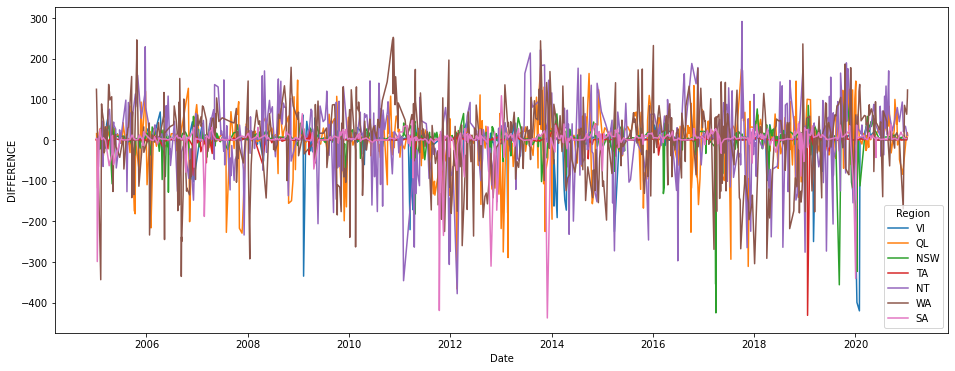

In [ ]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x="Date", y="DIFFERENCE", hue='Region', data=val_result)

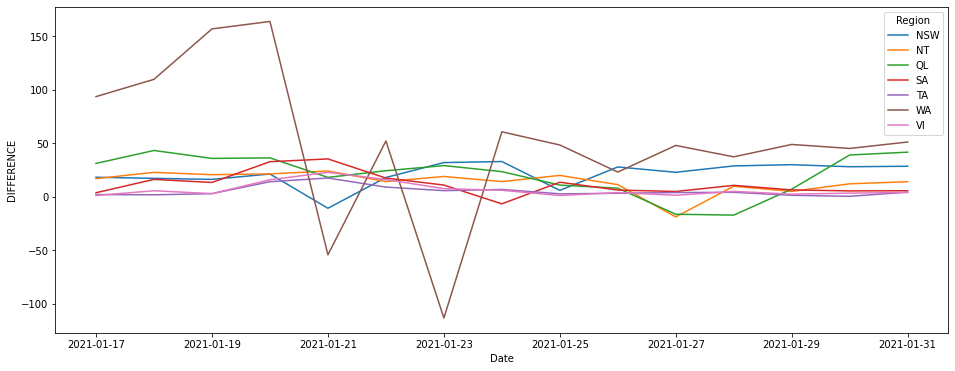

In [ ]:
plt.figure(figsize=(16, 6))
g = sns.lineplot(x="Date", y="DIFFERENCE", hue='Region', data=test_result, hue_order=['NSW', 'NT', 'QL', 'SA', 'TA', 'WA', 'VI'])

*   visualization of decision tree

In [ ]:
from sklearn.tree import export_graphviz
import pydot
feature_names = df.columns

tree = rf.estimators_[5]# Pull out one tree from the forest
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_names[:76], rounded = True, precision = 1)# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file
graph.write_png('tree.png')

In [ ]:
feature_names = df.columns
feature_names[1:]

Index(['Region', 'Precipitation_Max', 'Precipitation_Mean',
       'Precipitation_Min', 'Precipitation_Variance', 'RelativeHumidity_Max',
       'RelativeHumidity_Mean', 'RelativeHumidity_Min',
       'RelativeHumidity_Variance', 'SoilWaterContent_Max',
       ...
       'Vegetation_index_std-4', 'Vegetation_index_variance-4',
       'Shrubs_inflame_risk-4', 'Herbaceous vegetation_inflame_risk-4',
       'Cultivated and managed vegetation/agriculture (cropland)_inflame_risk-4',
       'Herbaceous wetland_inflame_risk-4',
       'Closed forest, deciduous broad leaf_inflame_risk-4',
       'Closed forest, unknown_inflame_risk-4',
       'Open forest, deciduous broad leaf_inflame_risk-4',
       'Open forest, unknown definitions_inflame_risk-4'],
      dtype='object', length=188)

In [ ]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

tree = rf.estimators_[5]

dot_data = export_graphviz(tree,filled=True,rounded=True,class_names=['Setosa','Versicolor','Virginica'], feature_names=feature_names[:76],out_file=None)
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')

*   getting feature importances

In [ ]:
#features = df.drop(columns=['Estimated_fire_area'], inplace=True)

importances = list(rf.feature_importances_)# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names[1:], importances)]# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];